<a href="https://colab.research.google.com/github/Emmanuel461/PML_2023_2024/blob/main/Homework6ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Script that implements a convolutional neural network with PyTorch over the mnist 8 by 8 practice data set
# code adapted from https://github.com/rasbt/machine-learning-book/blob/main/ch14/ch14_part1.py

'''
This code does the following:
    Splits the dataset into training and testing sets.
    Standardizes the features using StandardScaler.
    Reshapes dataset to fit the model
    Instantiates the model (CNN)
    Defines the loss function (Cross Entropy Loss) and optimizer (Adam).
    Trains the model for num_epochs epochs.
    Tests the trained model on the test set and evaluates the accuracy.
'''

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import  load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
import numpy as np

################################################################################ Data and parameters
SHOW=True # plot some digit for mnist 8*8

examples = load_digits() # https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html; 10 digits;  1797 examples
if SHOW:
    idx=random.randint(0,len(examples.target))
    print(examples.data[idx])
    print(examples.data[idx].reshape(8,8))
    print(examples.target[idx])
    plt.matshow(examples.data[idx].reshape(8,8), cmap=plt.cm.gray_r)
    plt.show()

X = examples.data # np.ndarray (1797, 64)
y = examples.target # (1797,)

# parameter constants
test_size=0.2
hidden_size = 8
batch_size= 256
num_epochs = 50
# Optimizer specific options
learning_rate=0.1
regularization_param=0.001
# Dropout: if p>0
dropout_p=0.1 # During training, randomly zeroes some of the elements of the input tensor with probability p.

########################################################################### train and test, pre-processing
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Standardize features
scaler = StandardScaler()
print(X_train.shape)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# mnist data set has examples with 64 attributes
# We need to reshape that information into NCHW (batch size, channels, height, width)
def reshape_mnist(X,W,H):
    X=X.reshape((X.shape[0],W,H))
    return np.expand_dims(X,1) # one channel

# Convert numpy arrays to PyTorch tensors of the right shape (labels do not need to be reshaped)
X_train_tensor = torch.tensor(reshape_mnist(X_train,8,8), dtype=torch.float32)
X_test_tensor = torch.tensor(reshape_mnist(X_test,8,8), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
print('Number of examples in training set:',X_train_tensor.shape)
print('Number of examples in test set:', X_test_tensor.shape)

# Instantiate the model
input_size = X_train_tensor.shape[1]
output_size = len(examples.target_names)

# Create dataloader where batch size is set (note: batchsize is the first parameter in NCHW)
train_dl=DataLoader(TensorDataset(X_train_tensor,y_train_tensor), batch_size, shuffle=True)
test_dl=DataLoader(TensorDataset(X_test_tensor,y_test_tensor), batch_size, shuffle=True)

if SHOW:
    class_names = [str(i) for i in range(10)]
    # Plot the images
    plt.figure(figsize=(10, 5))
    image_count = 0
    for images, labels in train_dl:
        for i in range(len(images)):
            plt.subplot(4, 5, image_count + 1)
            plt.imshow(np.transpose(images[i], (1, 2, 0)), cmap="gray")
            plt.title(class_names[labels[i]])
            plt.axis('off')
            image_count += 1
            if image_count >= 20:
                break
        if image_count >= 20:
            break
    plt.show()

###################################################################################### CNN  model
model=nn.Sequential(
    nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(8*4*4, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=dropout_p),
    nn.Linear(hidden_size, output_size)
)

'''
Compare with NN from previous script:
model=nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=dropout_p),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=dropout_p),
    nn.Linear(hidden_size, output_size)
)
'''
# model description
summary(model,(1,8,8)) # C, H, W

# Define loss function and optimizer
# Either torch.nn.NLLLoss or torch.nn.CrossEntropyLoss can be used: CrossEntropyLoss (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) implements softmax internally
loss_fn = nn.CrossEntropyLoss()

# Optimizer: optimizer object that will hold the current state and will update the parameters based on the computed gradients
# for param in model.parameters(): print(param.data)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization_param)

# Train the model and predict on test samples to estimate accuracy
# history stores losses, accuracy, actual labels and predictions
history = train(model, optimizer, loss_fn, num_epochs, train_dl, test_dl)

# plot losses along epochs
plot_losses(history)
# plot confusion matrix
plot_accuracy_from_predictions(history)
#plot_accuracy(hist)


In [ ]:
!pip install cifar10
!pip install keras

Number of examples in training set: torch.Size([50000, 3, 32, 32])
Number of examples in test set: torch.Size([10000, 3, 32, 32])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
           Flatten-4                 [-1, 8192]               0
            Linear-5                   [-1, 16]         131,088
       BatchNorm1d-6                   [-1, 16]              32
              ReLU-7                   [-1, 16]               0
            Linear-8                   [-1, 16]             272
       BatchNorm1d-9                   [-1, 16]              32
             ReLU-10                   [-1, 16]               0
          Dropout-11                   [-1, 16]               0
           Linear-12                 

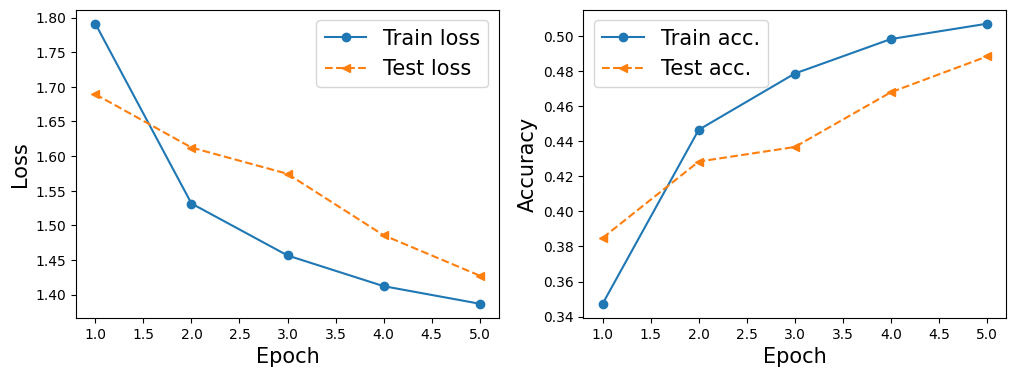

Accuracy on test set: 0.4550


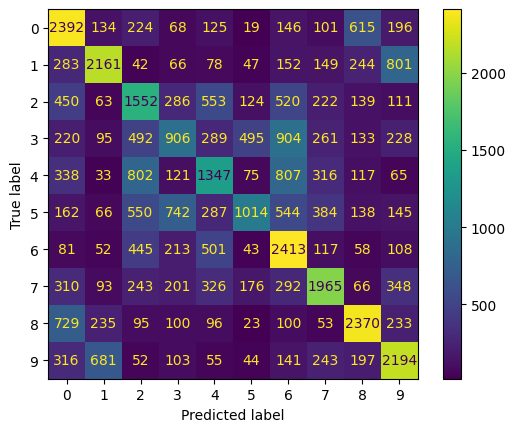

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

def train(model, optimizer, loss_fn, num_epochs, train_dl, valid_dl):
    '''
    Main function to train and test the model
    '''
    # lists to store losses and accuracies
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    # main loop through epochs
    for epoch in range(num_epochs):
        # training mode
        model.train()
        for x_batch, y_batch in train_dl:
            # core of the learning process: predict and fit
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # compute train loss and accuracy
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        # compute average loss per epoch
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        # put the model in evaluation mode
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                # predict
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
                if epoch == 0:
                    preds, actuals = torch.argmax(pred, dim=1), y_batch
                else:
                    preds = torch.cat((preds, torch.argmax(pred, dim=1)), dim=0)
                    actuals = torch.cat((actuals, y_batch), dim=0)
        # compute average loss per epoch
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        # print accuracy
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid, preds, actuals


def plot_accuracy_from_predictions(hist):
    ''' Creates and prints confusion matrix from a model and a set of examples
    Inputs
    ------
    hist: tuple
        where hist[4] is the list of predicted values for test and hist[5] are the actual labels
    '''
    pred = hist[4].numpy()
    actual = hist[5].numpy()
    labels = np.unique(actual)
    disp = ConfusionMatrixDisplay.from_predictions(actual, pred, labels=labels)
    # print global accuracy
    accuracy = np.sum(np.diagonal(disp.confusion_matrix)) / np.sum(disp.confusion_matrix)
    print(f'Accuracy on test set: {accuracy:.4f}')
    plt.show()


def plot_losses(hist):
    ''' plots train and test loss
    Input
    ------
    history, the output of function train()
    '''
    x_arr = np.arange(len(hist[0])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist[0], '-o', label='Train loss')
    ax.plot(x_arr, hist[1], '--<', label='Test loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15)
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist[2], '-o', label='Train acc.')
    ax.plot(x_arr, hist[3], '--<', label='Test acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

################################################################################ Data and parameters
SHOW = False # plot some digit for mnist 32*32

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

# Flatten y if needed
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

# Parámetros constantes
# test_size = 0.2
hidden_size = 16
batch_size = 250
output_size = 10
num_epochs = 5
learning_rate = 0.005
regularization_param = 0.001
dropout_p = 0.1


# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 32*32*3)).reshape(-1, 3, 32, 32)
X_test = scaler.transform(X_test.reshape(-1, 32*32*3)).reshape(-1, 3, 32, 32)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print('Number of examples in training set:', X_train_tensor.shape)
print('Number of examples in test set:', X_test_tensor.shape)

# Crear DataLoader para cargar los datos en lotes durante el entrenamiento y la prueba
train_dl = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size, shuffle=True)
test_dl = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size, shuffle=True)

if SHOW:
    class_names = [str(i) for i in range(10)]
    # Plot the images
    plt.figure(figsize=(10, 5))
    image_count = 0
    for images, labels in train_dl:
        for i in range(len(images)):
            plt.subplot(4, 5, image_count + 1)
            plt.imshow(np.transpose(images[i], (1, 2, 0)), cmap="gray") ## Revisar
            plt.title(class_names[labels[i]])
            plt.axis('off')
            image_count += 1
            if image_count >= 20:
                break
        if image_count >= 20:
            break
    plt.show()

###################################################################################### CNN  model
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(32*16*16, hidden_size), ### Cambio
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=dropout_p),
    nn.Linear(hidden_size, output_size)
)

# Model description
summary(model, (3, 32, 32)) # C, H, W

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization_param)

# Train the model and predict on test samples to estimate accuracy
history = train(model, optimizer, loss_fn, num_epochs, train_dl, test_dl)

# plot losses along epochs
plot_losses(history)
# plot confusion matrix
plot_accuracy_from_predictions(history)
